# Binary Classification with Pretrained VGG-19 :

![](https://miro.medium.com/max/1400/1*6U9FJ_se7SIuFKJRyPMHuA.png)

In this notebook I am going to demonstrate simple process to use **Transfer Learning** with **VISUAL GEOMETRY GROUP -19 (VGG-19)**.

Learn more about transfer learning [here](https://towardsdatascience.com/what-is-transfer-learning-8b1a0fa42b4).

* In this notebook I will a binary image classification task ( predict human or horse ) with VGG-19.

## Process of the Prediction:

The model **VGG19** is previously trained and saved on [imagenet](image-net.org). As the model is very deep , so it will need much time to train on this dataset. So, the main layers of the model will be using the weights when it was pretrained on *imagnet* thus will stay non-trainable.



We are going to do this task using [tensorflow 2](https://www.tensorflow.org/). So, keras would be automatically imported with tensorflow.
Checking the tensorflow version at first.

P.S : Change the accelerator to connect with GPU to make this process faster. It is demonstrated [here](https://www.kaggle.com/sagnik1511/animal-recognition-custom-cnn).

In [1]:
import tensorflow as tf
print('Version of tensorflow :',tf.__version__)

Version of tensorflow : 2.4.1


As the tensorflow version is greater than 2.0.0 so, we do not have to import keras separately.
Now  libraries what will be used in the whole process will be imported.

In [2]:
from keras.layers import Input,Dense,Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
from datetime import datetime
from keras.callbacks import ModelCheckpoint

## Loading Model & Tuning :

In the process the model VGG19 will be loaded and then it will be tuned to predict over the dataset.


We have to set the image size for making an input in the model.

In [3]:
# setting image size 
IMAGE_SIZE = [ 224 , 224 , 3 ]

# Load the model 
vgg = VGG19( include_top = False,
            input_shape = IMAGE_SIZE,
            weights = 'imagenet')

# Visualize the model
vgg.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

As the model will be using previous weights , it will remain untrained for now.

In [4]:
for  layer in vgg.layers:
    layer.trainable = False

Now we are going to customize the model to be trained on the selected dataset ( not imagenet ).

In [5]:
# Flattened the last layer
x = Flatten()(vgg.output)

# Created a new layer as output
prediction = Dense( 2 , activation = 'softmax' )(x)

# Join it with the model
model = Model( inputs = vgg.input , outputs = prediction )

# Visualize the model again
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now the model is being compiled with [adam optimizer](https://keras.io/api/optimizers/adam/) and other metrics.

In [6]:
# defining adam
adam=Adam()

# compining the model
model.compile( loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'] )

## Processing Train & Test Data :

Now the train and validation data will be processed to specifically trained on the VGG19 model.

In [7]:
# This will preprocces the data to make train data

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input ,
    rotation_range = 40 ,
    width_shift_range = 0.2 ,
    height_shift_range = 0.2 ,
    shear_range = 0.2 ,
    zoom_range = 0.2 ,
    horizontal_flip = True ,
    fill_mode = 'nearest'
)

# Doing similar for the test data also

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input ,
    rotation_range = 40 ,
    width_shift_range = 0.2 ,
    height_shift_range = 0.2 ,
    shear_range = 0.2 ,
    zoom_range = 0.2 ,
    horizontal_flip = True ,
    fill_mode = 'nearest'
)

Links of the data :

In [8]:
train_path = '/kaggle/input/horses-or-humans-dataset/horse-or-human/train'
test_path = '/kaggle/input/horses-or-humans-dataset/horse-or-human/validation'


Now processing the data

In [9]:
# train data
train_set = train_datagen.flow_from_directory(train_path,
                                            target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'categorical')

# test data
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size = ( 224 , 224 ),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Visualizing the data :

Just checkinh how the images of human and horses actually looks like in the dataset.

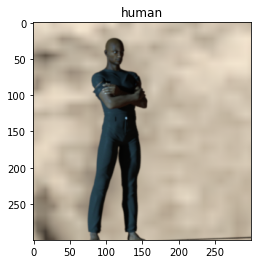

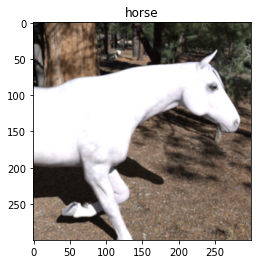

In [10]:
from matplotlib import image as mpimg
import os
for link in os.listdir(train_path):
  lk=train_path+'/'+link
  for lk1 in os.listdir(lk+'/'):
    path=lk+'/'+lk1
    img=mpimg.imread(path)
    plt.imshow(img)
    plt.title(link[:-1])
    plt.show()
    break

## Training and Prediction :

In this phase the model will be trained and will be ready to predict. Checkpoints will also be set to track the performance of the model.

In [11]:
checkpoint = ModelCheckpoint(filepath = 'vgg19.h5' , verbose = 2 , save_best_only = True )
callbacks = [checkpoint]
start = datetime.now()
model_history = model.fit( train_set,
                          validation_data = test_set,
                          epochs = 10,
                          steps_per_epoch = 5,
                          validation_steps = 32,
                          callbacks = callbacks,
                          verbose = 2)

duration = datetime.now() - start

print('Total elapsed time : ',duration)

Epoch 1/10
5/5 - 13s - loss: 3.5969 - accuracy: 0.7500 - val_loss: 0.2764 - val_accuracy: 0.9727

Epoch 00001: val_loss improved from inf to 0.27638, saving model to vgg19.h5
Epoch 2/10
5/5 - 3s - loss: 0.4969 - accuracy: 0.9688
Epoch 3/10
5/5 - 3s - loss: 0.8071 - accuracy: 0.9625
Epoch 4/10
5/5 - 3s - loss: 0.2366 - accuracy: 0.9750
Epoch 5/10
5/5 - 3s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
5/5 - 3s - loss: 0.0129 - accuracy: 0.9937
Epoch 7/10
5/5 - 3s - loss: 0.4130 - accuracy: 0.9812
Epoch 8/10
5/5 - 3s - loss: 0.1459 - accuracy: 0.9875
Epoch 9/10
5/5 - 3s - loss: 4.6792e-04 - accuracy: 1.0000
Epoch 10/10
5/5 - 3s - loss: 0.0313 - accuracy: 0.9875
Total elapsed time :  0:00:44.956961


We can see that the model slightly overfitetd but predicted nicely over the train and validation.

Thus we can tell that this pretrained model really works up to mark :)

# THANK YOU for visiting.

If you like this notebook do **upvote**,

You can visit my other works in [kaggle](kaggle.com/sagnik1511/code) or in [github](github.com/sagnik1511).

![](https://i.ytimg.com/vi/rU8ygyLuuIU/maxresdefault.jpg)